# Final Project DTSA 5509 
## AUG 20224

## Project Description:
To develop and compare multiple machine learning models to predict the likelihood of a person having diabetes based on various health indicators. This involves applying EDA to understand the data, building and tuning models, and evaluating their performance to identify the best predictive model. The goal is to identify which health indicators are most strongly associated with diabetes and to identify a model that can accurately predict diabetes risk in patients.

The data we will be using for this project is from the CDC Github Repository: https://github.com/uci-ml-repo/ucimlrepo

Below you will see I have ran the metadata file to give you a sense of what each varaible (feautures) each mean and what do they entail

Data: https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators


# Load Packages

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
%matplotlib inline

# Load Data

In [3]:
!pip3 install -U ucimlrepo 

In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
df = cdc_diabetes_health_indicators.data.original 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
print(cdc_diabetes_health_indicators.variables) 


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [7]:
# Inspect Data
print(df.info())
print(df.head())
print(df['Diabetes_binary'].value_counts())

# Descriptive Statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   ID                    253680 non-null  int64
 1   Diabetes_binary       253680 non-null  int64
 2   HighBP                253680 non-null  int64
 3   HighChol              253680 non-null  int64
 4   CholCheck             253680 non-null  int64
 5   BMI                   253680 non-null  int64
 6   Smoker                253680 non-null  int64
 7   Stroke                253680 non-null  int64
 8   HeartDiseaseorAttack  253680 non-null  int64
 9   PhysActivity          253680 non-null  int64
 10  Fruits                253680 non-null  int64
 11  Veggies               253680 non-null  int64
 12  HvyAlcoholConsump     253680 non-null  int64
 13  AnyHealthcare         253680 non-null  int64
 14  NoDocbcCost           253680 non-null  int64
 15  GenHlth               253680 non-n

## Data Visualization


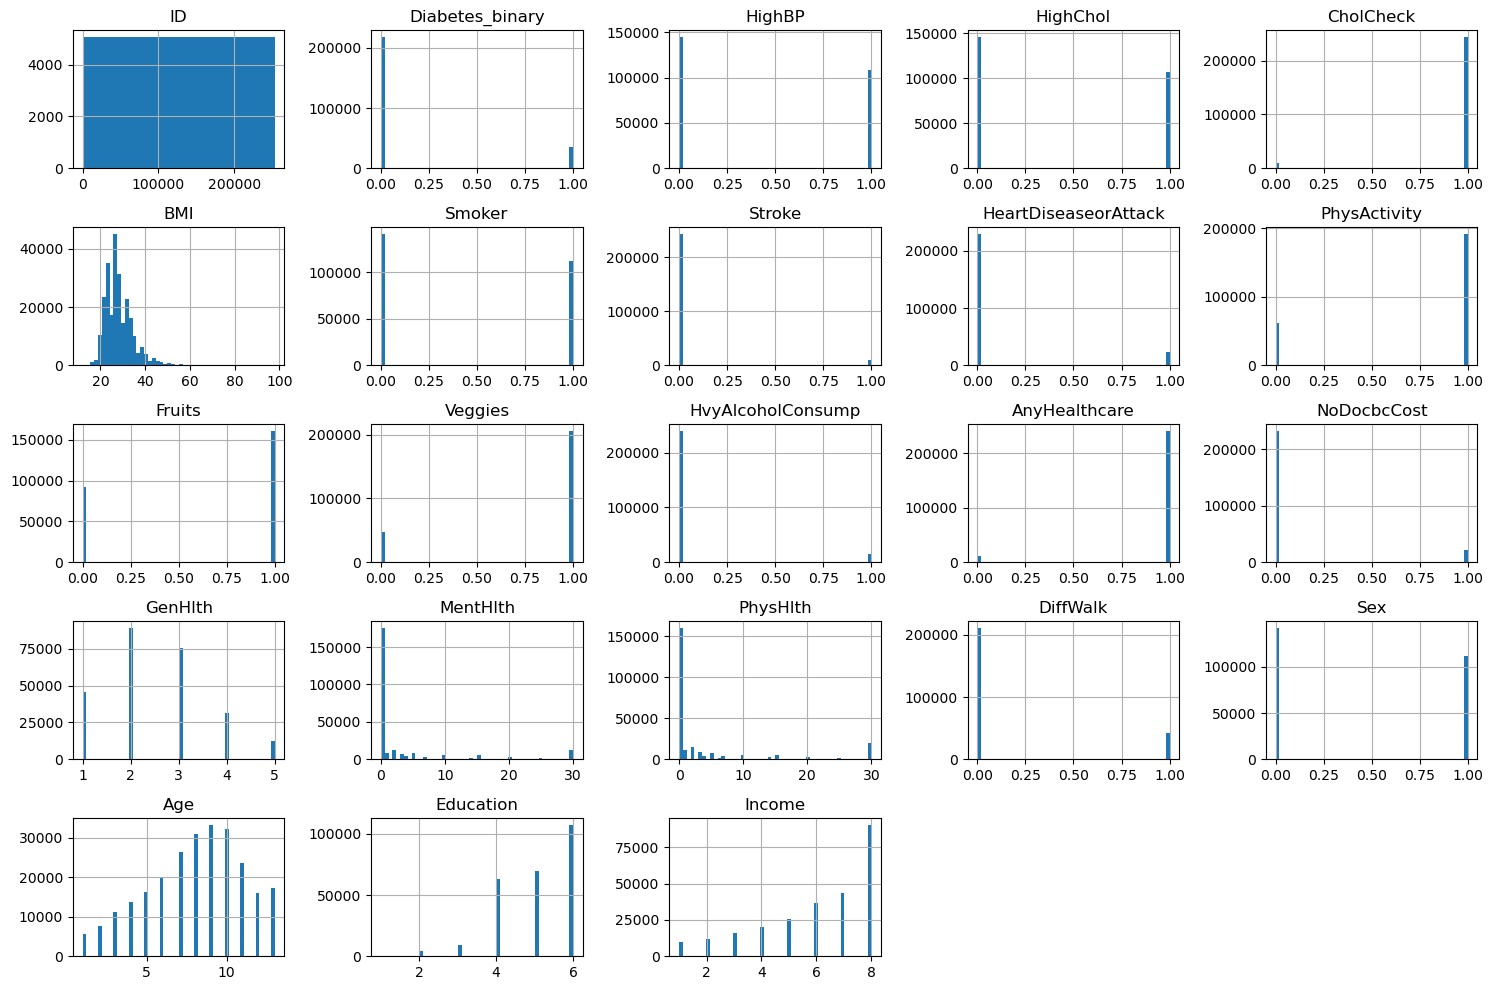

In [8]:
# Histograms for Distribution of Features
df.hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

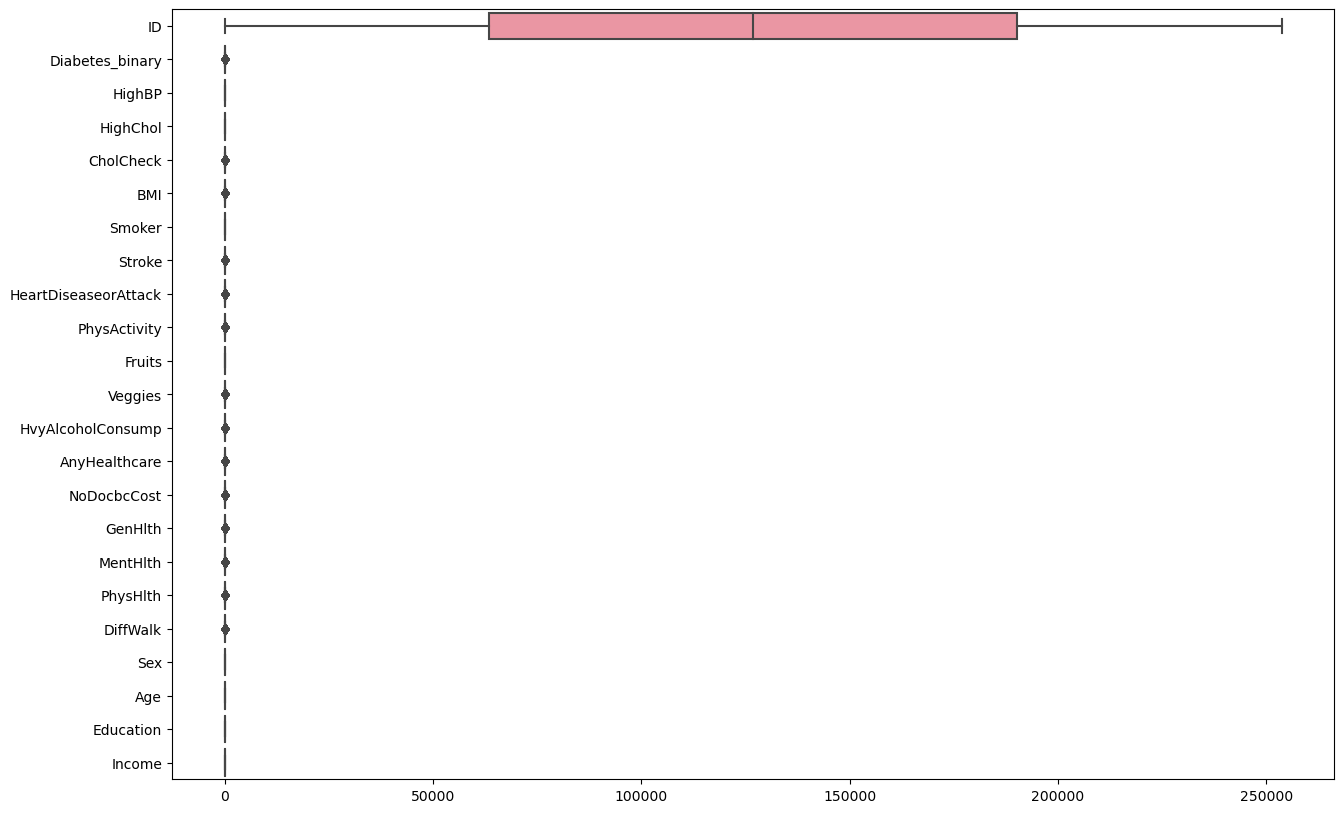

In [9]:
# Box-Plots to Detect Outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient="h")
plt.show()

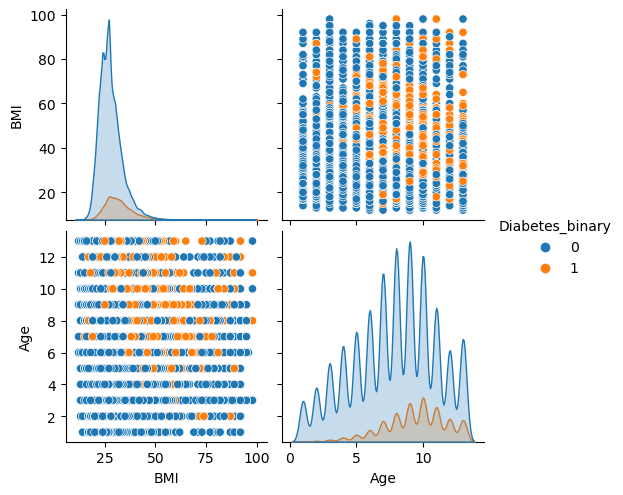

In [10]:
# Scatter Plots to Examine Relationships
sns.pairplot(df[['BMI', 'Age','GenHlth','Diabetes_binary']], hue='Diabetes_binary')
plt.show()

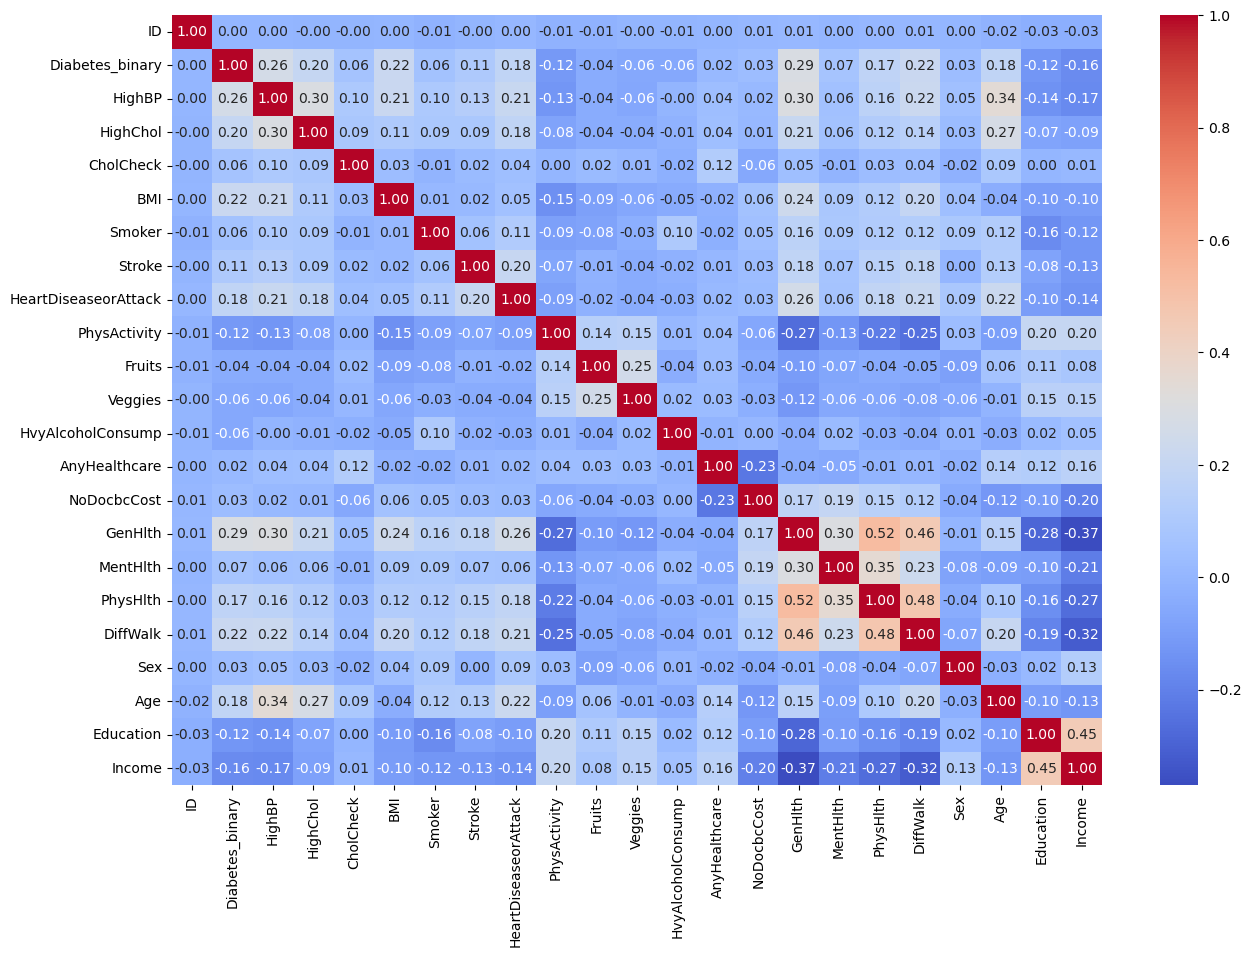

In [11]:
# Correlation Matrix
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Preliminary Hypothesis
According to the different plots and bar charts we can already identify that the top 3 feautres that impact whther or not a patient can have diabetes is going to be:
1. Age
2. GenHlth
3. HighBP                

## Data Cleaning


In [12]:
# Handle Missing Values
print(df.isnull().sum())
df = df.fillna(method='ffill')  # Forward fill as an example


ID                      0
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [13]:
# Detect and Remove Outliers (using Z-score)
from scipy import stats
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows where any z-score is greater than 3


In [14]:
# Feature Selection and Scaling
X = df.drop(columns=['Diabetes_binary', 'ID'])
y = df['Diabetes_binary']

In [16]:
# Standardize the Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Supervised Machine Learning Models

##  Model Building and Evaluation

In [23]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
}

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}\n")

# Evaluate the best Random Forest model from grid search
y_pred_rf = best_rf_model.predict(X_test)
print("Best Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_rf)}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45180
           1       0.50      0.10      0.17      5891

    accuracy                           0.88     51071
   macro avg       0.70      0.54      0.55     51071
weighted avg       0.85      0.88      0.85     51071

ROC AUC Score: 0.5441484838668299

Model: Random Forest
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     45180
           1       0.42      0.11      0.18      5891

    accuracy                           0.88     51071
   macro avg       0.66      0.55      0.56     51071
weighted avg       0.84      0.88      0.85     51071

ROC AUC Score: 0.5458878325134738

Best Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45180
           1       0.56      0.08      0.13      5891

    accuracy              

## Additional Model Evaluation

In [28]:
# Define the model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Model: K-Nearest Neighbors")
print(classification_report(y_test, y_pred_knn))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_knn))

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     45180
           1       0.37      0.15      0.21      5891

    accuracy                           0.87     51071
   macro avg       0.63      0.56      0.57     51071
weighted avg       0.84      0.87      0.85     51071

ROC AUC Score: 0.6945565894628919


## Model Interpretation and Reporting

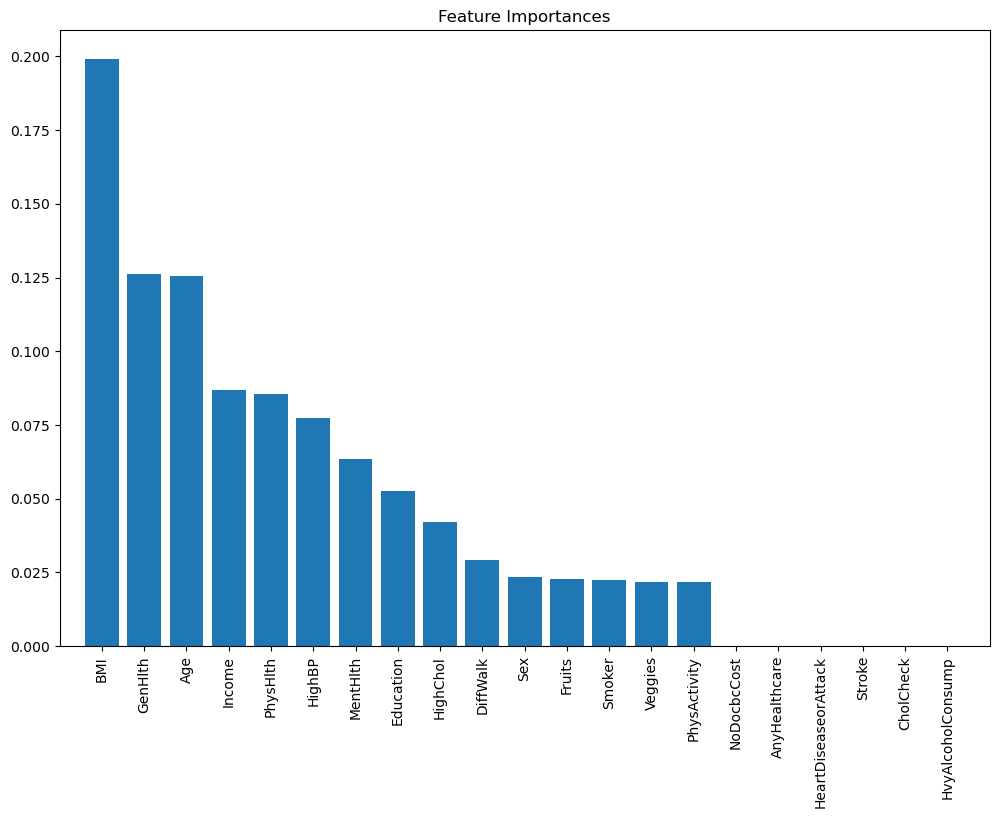

['best_rf_model.pkl']

In [25]:
# Feature importances from the best Random Forest model
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Save the final model for future use
import joblib
joblib.dump(best_rf_model, 'best_rf_model.pkl')

## Findings and Conclusion: Best Model for Diabetes Prediction

In our analysis, we compared the performance of Logistic Regression and Random Forest models for predicting diabetes based on various health indicators. The results show that both models perform well in terms of overall accuracy, achieving an accuracy of 88-89%. However, when we examine the performance metrics for the minority class (those with diabetes, labeled as 1), the results indicate challenges in correctly identifying these cases.

Logistic Regression: This model achieved an overall accuracy of 88%, with a high precision of 0.89 for the majority class (no diabetes). However, the precision for the minority class (diabetes) was much lower at 0.50, with a recall of only 0.10, resulting in an F1-score of 0.17. The ROC AUC score of 0.544 further indicates that the model struggles to distinguish between the two classes.

Random Forest: The Random Forest model also achieved an accuracy of 88%, with similar performance for the majority class. However, the precision and recall for the minority class were even lower than Logistic Regression, with an F1-score of 0.18 and an ROC AUC score of 0.546. Despite tuning, the best Random Forest model still had difficulty in accurately identifying those with diabetes, showing a recall of only 0.08 for the positive class.

K-Nearest Neighbors (KNN): This model performed comparably to the others in terms of accuracy, achieving a precision of 0.90 for non-diabetic cases. However, it showed poor recall for diabetic cases (0.15) and a moderate ROC AUC score of 0.695, reflecting an ongoing challenge in accurately identifying diabetic patients.

Additionally, an analysis of feature importance revealed that BMI, General Health (GenHlth), and Age were the most influential predictors of diabetes across both models. This emphasizes the significance of these health and demographic factors in predicting the likelihood of diabetes.

These results suggest that while all models are effective at predicting the majority class, they struggle with the minority class, leading to poor recall and F1-scores for individuals with diabetes. 

## The Future of Diabetes Prediction:
**Model Performance and Challenges**: The models show strong performance in identifying individuals who do not have diabetes (high precision and recall for the majority class). However, they struggle significantly in accurately predicting those who do have diabetes, as reflected by the low precision, recall, and F1-scores for the diabetic class (label 1). This indicates that while the models are good at ruling out non-diabetic cases, they are not as effective in identifying true diabetic cases. This presents a challenge in real-world applications where accurately identifying those at risk of diabetes is crucial.

**Importance of Features**: The analysis highlighted that BMI, General Health (GenHlth), and Age are significant predictors in the models. This suggests that these factors play a critical role in diabetes risk assessment, aligning with existing medical knowledge. These insights can guide the development of more targeted interventions and preventive measures focusing on these key health indicators.

**Need for Advanced Models and Data**: The modest performance of these models, particularly in detecting diabetes cases, suggests that more advanced machine learning models or improved data quality might be necessary for better predictive accuracy. Techniques like ensemble learning, feature engineering, or access to more granular health data could enhance model performance.

To explore these advanced models look into these packages and have play with them, I personally couldn't due to access issues: !pip install xgboost lightgbm catboost
